In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')
train.drop(['PassengerId', 'Name', 'Ticket', 'Embarked'], axis=1, inplace=True)
train.describe(include='all')
train.fillna(value={'Age': train['Age'].mean()}, inplace=True)
train.dropna(axis=1, inplace=True)
train['Age'] = train['Age'] / (train['Age'].max() - train['Age'].min())
train['Fare'] = train['Fare'] / (train['Fare'].max() - train['Fare'].min())
train.describe(include='all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891,891.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN
top,NaN,NaN,male,NaN,NaN,NaN,NaN
freq,NaN,NaN,577,NaN,NaN,NaN,NaN
mean,0.383838,2.308642,NaN,0.373198,0.523008,0.381594,0.062858
std,0.486592,0.836071,NaN,0.163383,1.102743,0.806057,0.096995
min,0.000000,1.000000,NaN,0.005278,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,0.276451,0.000000,0.000000,0.015440
50%,0.000000,3.000000,NaN,0.373198,0.000000,0.000000,0.028213
75%,1.000000,3.000000,NaN,0.439809,1.000000,0.000000,0.060508


In [28]:
X_train = np.zeros((9, train.shape[0]))
Y_train = np.zeros((train.shape[0], 1))

for i, x in train.iterrows():
    X_train[x['Pclass'] - 1, i] = 1
    if x['Sex'] == 'M':
        X_train[3, i] = 1
    else:
        X_train[4, i] = 1
    X_train[5:, i] = x['Age'], x['SibSp'], x['Parch'], x['Fare']
    Y_train[i] = x['Survived']

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [6]:
def relu(z):
    return np.maximum(0, z)

In [44]:
def initialize_parameters(layers_dims):
    L = len(layers_dims)
    parameters = {}
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    
    return parameters

In [55]:
def forward_propagation(X, parameters):
    L = len(parameters) // 2
    A_prev = X
    caches = []
    
    for l in range(1, L):
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        
        Z = np.dot(W, A_prev) + b
        caches.append((A_prev, W, b, Z))
        A_prev = relu(Z)
    
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    
    Z = np.dot(W, A_prev) + b
    caches.append((A_prev, W, b, Z))
    AL = sigmoid(Z)
    
    return AL, caches

In [10]:
def compute_cost(AL, Y):
    m = Y.shape[0]
    
    return (1 / m) * (np.dot(np.log(AL), Y) + np.dot(np.log(1 - AL), 1 - Y))

In [12]:
def dsigmoid(z):
    g = sigmoid(z)
    return g * (1 - g)

In [18]:
def drelu(z):
    return (z > 0) * 1

In [71]:
def backward_propagation(AL, Y, caches):
    grads = {}
    m = Y.shape[0]
    L = len(caches)
    dAL = np.divide(1 - Y.T, 1 - AL) - np.divide(Y.T, AL)
    A_prev, W, b, Z = caches[L - 1]
    
    dZ = dAL * dsigmoid(Z)
    grads['dW' + str(L)] = (1 / m) * np.dot(dZ, A_prev.T)
    grads['db' + str(L)] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    for l in reversed(range(1, L)):
        A_prev, W, b, Z = caches[l - 1]
        dZ = dA_prev * drelu(Z)
        grads['dW' + str(l)] = (1 / m) * np.dot(dZ, A_prev.T)
        grads['db' + str(l)] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
    
    return grads

In [46]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    
    for l in range(1, L):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    
    return parameters

In [88]:
def neural_network(X, Y, layers_dims, learning_rate=0.01, num_iterations=2500, print_costs=False):
    parameters = initialize_parameters(layers_dims)
    costs = []
    
    for i in range(num_iterations):
        AL, caches = forward_propagation(X, parameters)
        cost = compute_cost(AL, Y)
        grads = backward_propagation(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        
        costs.append(cost)
        if print_costs and i % 1000 == 0:
            print('Cost after ', i, ' iteration:', cost)
    
    Y_pred = (AL > 0.5) * 1
    print('Training accuracy:', (100 / Y.shape[0]) * (np.dot(Y_pred, Y) + np.dot(1 - Y_pred, 1 - Y)))
    
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    
    return parameters

Cost after  0  iteration: [[ 0.69314427]]
Cost after  500  iteration: [[ 0.6080888]]
Cost after  1000  iteration: [[ 0.6036739]]
Cost after  1500  iteration: [[ 0.58390413]]
Cost after  2000  iteration: [[ 0.56167534]]
Cost after  2500  iteration: [[ 0.55820314]]
Cost after  3000  iteration: [[ 0.55653219]]
Cost after  3500  iteration: [[ 0.55470719]]
Cost after  4000  iteration: [[ 0.55334562]]
Cost after  4500  iteration: [[ 0.55235276]]
Cost after  5000  iteration: [[ 0.55147565]]
Cost after  5500  iteration: [[ 0.55045717]]
Cost after  6000  iteration: [[ 0.54954206]]
Cost after  6500  iteration: [[ 0.54867342]]
Cost after  7000  iteration: [[ 0.54798386]]
Cost after  7500  iteration: [[ 0.54717743]]
Cost after  8000  iteration: [[ 0.54651805]]
Cost after  8500  iteration: [[ 0.54606068]]
Cost after  9000  iteration: [[ 0.54533486]]
Cost after  9500  iteration: [[ 0.54492271]]
Cost after  10000  iteration: [[ 0.54453248]]
Cost after  10500  iteration: [[ 0.54395982]]
Cost after  11

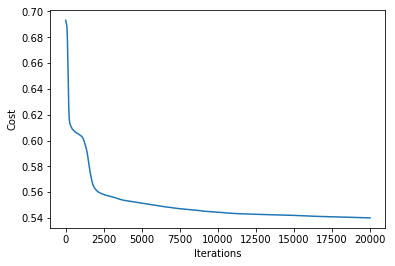

In [94]:
layers_dims = [9, 50, 10, 1]
model = neural_network(X_train, Y_train, layers_dims, 5, 20000, print_costs=True)

In [95]:
test = pd.read_csv('test.csv')
test.drop(['Name', 'Ticket', 'Embarked'], axis=1, inplace=True)
test.fillna(value={'Age': train['Age'].mean()}, inplace=True)
test.fillna(value={'Fare': train['Fare'].mean()}, inplace=True)
test.dropna(axis=1, inplace=True)
test['Age'] = test['Age'] / (test['Age'].max() - test['Age'].min())
test['Fare'] = test['Fare'] / (test['Fare'].max() - test['Fare'].min())
test.describe(include='all')

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418,418.000000,418.000000,418.000000,418.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN
top,NaN,NaN,male,NaN,NaN,NaN,NaN
freq,NaN,NaN,266,NaN,NaN,NaN,NaN
mean,1100.500000,2.265550,NaN,0.318094,0.447368,0.392344,0.069374
std,120.810458,0.841838,NaN,0.230711,0.896760,0.981429,0.109046
min,892.000000,1.000000,NaN,0.002242,0.000000,0.000000,0.000000
25%,996.250000,1.000000,NaN,0.118687,0.000000,0.000000,0.015412
50%,1100.500000,3.000000,NaN,0.316497,0.000000,0.000000,0.028213
75%,1204.750000,3.000000,NaN,0.471449,1.000000,0.000000,0.061429


In [96]:
X = np.zeros((9, test.shape[0]))

for i, x in test.iterrows():
    X[x['Pclass'] - 1, i] = 1
    if x['Sex'] == 'M':
        X[3, i] = 1
    else:
        X[4, i] = 1
    X[5:, i] = x['Age'], x['SibSp'], x['Parch'], x['Fare']

In [103]:
def predict(X, parameters):
    L = len(parameters) // 2
    A_prev = X
    
    for l in range(1, L):
        Z = np.dot(parameters['W' + str(l)], A_prev) + parameters['b' + str(l)]
        A_prev = relu(Z)
    
    Z = np.dot(parameters['W' + str(L)], A_prev) + parameters['b' + str(L)]
    return (sigmoid(Z) > 0.5) * 1

In [104]:
Y_pred = predict(X, model).T
print(Y_pred.shape)
test['Survived'] = Y_pred
test[['PassengerId', 'Survived']].astype(int).to_csv('submission_neural_network.csv', index=False)

(418, 1)
